# BoostDM_Rules_comparisons

Includes the differences between the manualy curated rules with BoostDM

0. Import data
1. Comparison of expert curated rules unique drivers
2. Comparison of expert curated rules unique drivers in UKB
3. Comparison of expert curated rules total drivers in UKB (Supplemental Figure S19C)
4. Comparison of expert curated rules (intersection) with boostDM-CH. Total drivers in UKB (Figure 6A)
5. Comparison of expert curated rules (intersection) with boostDM-CH. Total ASXL1 drivers in UKB (Supplemental Figure S20A)
6. Comparison of expert curated rules (intersection) with boostDM-CH. Gene frequencies (Supplementary Figure S19A, B)


In [1]:
import click
import gzip
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2


import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# 0. Import data

In [2]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

In [3]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

203351

In [4]:
### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.columns

# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
ukb200K_ch_cancer.columns

/tmp/jobs/jramis/9874679/ipykernel_11255/2406461110.py:3: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_nonDriver',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       'var_Cervical_post', 'var_Cervical_pre', 'var_Sarcoma_years',
       'var_Sarcoma_var', 'var_Sarcoma_post', 'var_Sarcoma_pre',
       'var_Testicular_years', 'var_Testicular_var', 'var_Testicular_post',
       'var_Testicular_pre'],
      dtype='object', length=263)

In [5]:
# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

In [6]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })

In [7]:
# Select mutations in cases without prior hemaatological cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions_nonHN = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)]
len(boostDM_predictions_nonHN)

201857

In [8]:
# Exclude MDM4, CHEK2
boostDM_predictions_nonHN = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['SYMBOL'].isin(['MDM4', 'CHEK2'])]
len(boostDM_predictions_nonHN)

184379

In [9]:
### Upload boostDM-CH predictions
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t', compression='gzip')
Rules_matrix['ID2'] = Rules_matrix['chr'].astype(str) +"-"+\
                            Rules_matrix['pos'].astype(str) +"-"+\
                            Rules_matrix['alt'].astype(str)
Rules_matrix

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,ID2
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-C
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-G
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0,20-32358779-T
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-C
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-C
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-T
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-A
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-G


In [10]:
#Select CH drivers by different methods
BoostDM_dirvers = Rules_matrix[Rules_matrix['boostDM_class']==1]
Niroula_dirvers = Rules_matrix[Rules_matrix['Niroula']==1]
Bick_dirvers = Rules_matrix[Rules_matrix['Bick']==1]
WHO_dirvers = Rules_matrix[Rules_matrix['WHO']==1]

In [11]:
boostDM_predictions_nonHN['BoostDM'] = np.where(boostDM_predictions_nonHN['ID2'].isin(BoostDM_dirvers['ID2'].to_list()), 1, 0)
print('BoostDM_Done')
boostDM_predictions_nonHN['Niroula'] = np.where(boostDM_predictions_nonHN['ID2'].isin(Niroula_dirvers['ID2'].to_list()), 1, 0)
print('Niroula_Done')
boostDM_predictions_nonHN['Bick'] = np.where(boostDM_predictions_nonHN['ID2'].isin(Bick_dirvers['ID2'].to_list()), 1, 0)
print('Bick_Done')
boostDM_predictions_nonHN['WHO'] = np.where(boostDM_predictions_nonHN['ID2'].isin(WHO_dirvers['ID2'].to_list()), 1, 0)
print('WHO_Done')

len(boostDM_predictions_nonHN)

BoostDM_Done
Niroula_Done
Bick_Done
WHO_Done


184379

# 1. Comparison of expert curated rules unique drivers

Text(0.0, 1.0, 'BoostDM vs expert-curated rules drivers (10 genes)\n\n                                                      Exclusive mutaitons ')

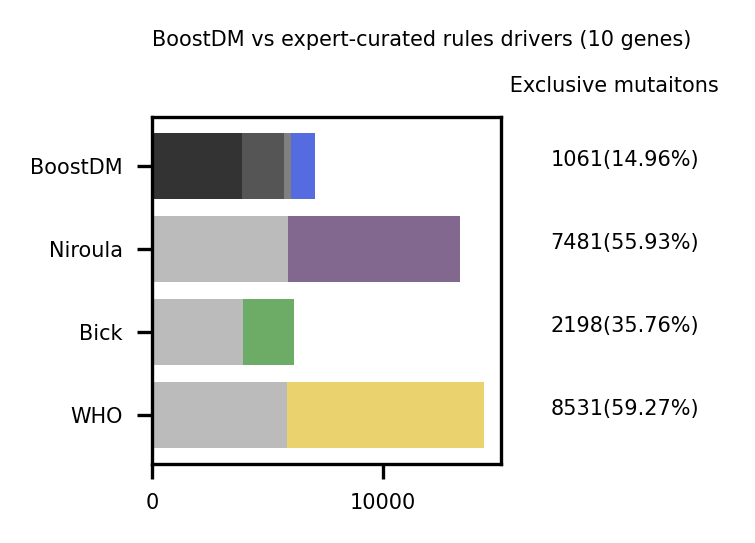

In [12]:
######
#BARPLOT
######
plt.figure(figsize=(1.5, 1.5))

Rules_matrix_comp = Rules_matrix[~Rules_matrix['gene'].isin(['CHEK2', 'MDM4'])]

BoostDM = len(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)]['ID2'].to_list())

BoostDM_exc = len(set(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()))

Overlapping_1 = len(set(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))

Overlapping_2 = len(set(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))

Overlapping_all = len(set(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))


Niroula = len(Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)]['ID2'].to_list())

Niroula_exc = len(set(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==0)&(Rules_matrix_comp['Niroula']==1)]['ID2'].to_list()))

Overlapping_Niroula = len(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1) &\
                                                    (Rules_matrix_comp['Niroula']==1)]['ID2'].to_list())

Bick = len(Rules_matrix_comp[(Rules_matrix_comp['Bick']==1)]['ID2'].to_list())

Bick_exc = len(set(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==0)&(Rules_matrix_comp['Bick']==1)]['ID2'].to_list()))

Overlapping_Bick = len(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1) &\
                                                 (Rules_matrix_comp['Bick']==1)]['ID2'].to_list())

WHO = len(Rules_matrix_comp[(Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

WHO_exc = len(set(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))

Overlapping_WHO = len(Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1) &\
                                                (Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

# # create data
x = ['WHO', 'Bick', 'Niroula', 'BoostDM']
y1 = [0, 0, 0, Overlapping_all]
y2 = [0, 0, 0, Overlapping_2]
# y3 = [Overlapping_WHO, Overlapping_Bick, Overlapping_Niroula, Overlapping_1]
y3 = [0, 0, 0, Overlapping_1]
y33 = [Overlapping_WHO, Overlapping_Bick, Overlapping_Niroula, 0]
y4 = [0, 0, 0, BoostDM_exc]
y5 = [0, 0, Niroula_exc, 0]
y6 = [0, Bick_exc, 0, 0]
y7 = [WHO_exc, 0, 0, 0]
h = 0.6
size_param = 5

max_len = max([BoostDM,Niroula,Bick,WHO])
plt.barh(x, y1, color='#333333')
plt.barh(x, y2, left=y1, color='#555555')
plt.barh(x, y3, left=[sum(pair) for pair in zip(y1, y2)] , color='grey')
plt.barh(x, y33, left=[sum(pair) for pair in zip(y1, y2, y3)] , color='#bbbbbb')
plt.barh(x, y4, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#556CE0')
plt.barh(x, y5, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#82678E')
plt.barh(x, y6, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#6DAC67')
plt.barh(x, y7, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#EAD36E')
plt.text(max_len+(max_len/5), 0, str(round(WHO_exc))+'('+str(round((WHO_exc)/WHO*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 1, str(round(Bick_exc))+'('+str(round((Bick_exc)/Bick*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 2, str(round(Niroula_exc))+'('+str(round((Niroula_exc)/Niroula*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 3, str(round(BoostDM_exc))+'('+str(round((BoostDM_exc)/BoostDM*100, 2))+'%)', size=size_param)
plt.yticks(fontsize=size_param)
plt.xticks(fontsize=size_param)
plt.title("BoostDM vs expert-curated rules drivers (10 genes)\n\n                                                      Exclusive mutaitons ", fontsize=size_param, loc="left") 

In [15]:
Rules_matrix_comp[(Rules_matrix_comp['boostDM_class']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==0)]['gene'].value_counts()

SF3B1     288
TET2      286
U2AF1     242
ASXL1     132
DNMT3A     45
SRSF2      32
GNAS       28
PPM1D       8
Name: gene, dtype: int64

# 2- Comparison of expert curated rules unique drivers in UKB

Text(0.0, 1.0, 'BoostDM vs expert-curated rules drivers (10 genes)\nUnique drivers in UKB\n                                                      Exclusive mutaitons ')

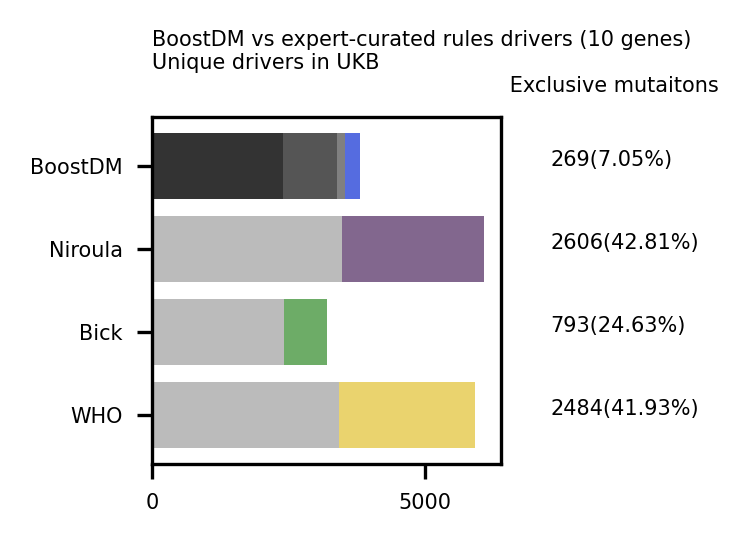

In [13]:
######
#BARPLOT
######
plt.figure(figsize=(1.5, 1.5))

Rules_matrix_comp = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['SYMBOL'].isin(['CHEK2', 'MDM4'])]

BoostDM = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)]['ID2'].to_list()))

BoostDM_exc = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()))

Overlapping_1 = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))

Overlapping_2 = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))

Overlapping_all = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))


Niroula = len(set(Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)]['ID2'].to_list()))

Niroula_exc = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==0)&(Rules_matrix_comp['Niroula']==1)]['ID2'].to_list()))

Overlapping_Niroula = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1) &\
                                                    (Rules_matrix_comp['Niroula']==1)]['ID2'].to_list()))

Bick = len(set(Rules_matrix_comp[(Rules_matrix_comp['Bick']==1)]['ID2'].to_list()))

Bick_exc = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==0)&(Rules_matrix_comp['Bick']==1)]['ID2'].to_list()))

Overlapping_Bick = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1) &\
                                                 (Rules_matrix_comp['Bick']==1)]['ID2'].to_list()))

WHO = len(set(Rules_matrix_comp[(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))

WHO_exc = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))

Overlapping_WHO = len(set(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1) &\
                                                (Rules_matrix_comp['WHO']==1)]['ID2'].to_list()))

# # create data
x = ['WHO', 'Bick', 'Niroula', 'BoostDM']
y1 = [0, 0, 0, Overlapping_all]
y2 = [0, 0, 0, Overlapping_2]
y3 = [0, 0, 0, Overlapping_1]
y33 = [Overlapping_WHO, Overlapping_Bick, Overlapping_Niroula, 0]
y4 = [0, 0, 0, BoostDM_exc]
y5 = [0, 0, Niroula_exc, 0]
y6 = [0, Bick_exc, 0, 0]
y7 = [WHO_exc, 0, 0, 0]
h = 0.6
size_param = 5

# plot bars in stack manner
max_len = max([BoostDM,Niroula,Bick,WHO])
plt.barh(x, y1, color='#333333')
plt.barh(x, y2, left=y1, color='#555555')
plt.barh(x, y3, left=[sum(pair) for pair in zip(y1, y2)] , color='grey')
plt.barh(x, y33, left=[sum(pair) for pair in zip(y1, y2, y3)] , color='#bbbbbb')
plt.barh(x, y4, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#556CE0')
plt.barh(x, y5, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#82678E')
plt.barh(x, y6, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#6DAC67')
plt.barh(x, y7, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#EAD36E')
plt.text(max_len+(max_len/5), 0, str(round(WHO_exc))+'('+str(round((WHO_exc)/WHO*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 1, str(round(Bick_exc))+'('+str(round((Bick_exc)/Bick*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 2, str(round(Niroula_exc))+'('+str(round((Niroula_exc)/Niroula*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 3, str(round(BoostDM_exc))+'('+str(round((BoostDM_exc)/BoostDM*100, 2))+'%)', size=size_param)
plt.yticks(fontsize=size_param)
plt.xticks(fontsize=size_param)
plt.title("BoostDM vs expert-curated rules drivers (10 genes)\nUnique drivers in UKB\n                                                      Exclusive mutaitons ", fontsize=size_param, loc="left") 

# 3. Comparison of expert curated rules total drivers in UKB

Text(0.0, 1.0, 'BoostDM vs expert-curated rules drivers (10 genes)\nAll drivers in UKB\n                                                      Exclusive mutaitons ')

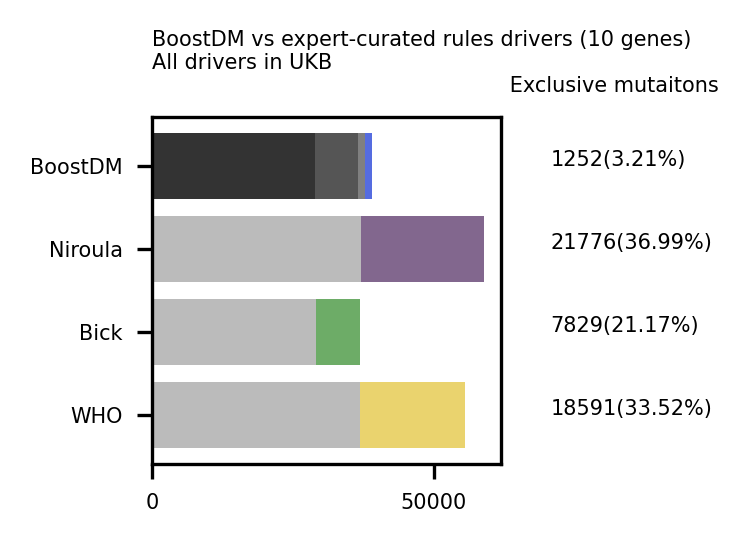

In [14]:
######
#BARPLOT
######

plt.figure(figsize=(1.5, 1.5))

Rules_matrix_comp = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['SYMBOL'].isin(['CHEK2', 'MDM4'])]

BoostDM = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)]['ID2'].to_list())

BoostDM_exc = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list())

Overlapping_1 = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

Overlapping_2 = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==0)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list()+\
        
        Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==0)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

Overlapping_all = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Niroula']==1)&\
                     (Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list())


Niroula = len(Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)]['ID2'].to_list())

Niroula_exc = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==0)&(Rules_matrix_comp['Niroula']==1)]['ID2'].to_list())

Overlapping_Niroula = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1) &\
                                                    (Rules_matrix_comp['Niroula']==1)]['ID2'].to_list())

Bick = len(Rules_matrix_comp[(Rules_matrix_comp['Bick']==1)]['ID2'].to_list())

Bick_exc = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==0)&(Rules_matrix_comp['Bick']==1)]['ID2'].to_list())

Overlapping_Bick = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1) &\
                                                 (Rules_matrix_comp['Bick']==1)]['ID2'].to_list())

WHO = len(Rules_matrix_comp[(Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

WHO_exc = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==0)&(Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

Overlapping_WHO = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1) &\
                                                (Rules_matrix_comp['WHO']==1)]['ID2'].to_list())


# # create data
x = ['WHO', 'Bick', 'Niroula', 'BoostDM']
y1 = [0, 0, 0, Overlapping_all]
y2 = [0, 0, 0, Overlapping_2]
# y3 = [Overlapping_WHO, Overlapping_Bick, Overlapping_Niroula, Overlapping_1]
y3 = [0, 0, 0, Overlapping_1]
y33 = [Overlapping_WHO, Overlapping_Bick, Overlapping_Niroula, 0]
y4 = [0, 0, 0, BoostDM_exc]
y5 = [0, 0, Niroula_exc, 0]
y6 = [0, Bick_exc, 0, 0]
y7 = [WHO_exc, 0, 0, 0]
h = 0.6
size_param = 5

# plot bars in stack manner
#     plt.figure(figsize=(4, 2))
max_len = max([BoostDM,Niroula,Bick,WHO])
plt.barh(x, y1, color='#333333')
plt.barh(x, y2, left=y1, color='#555555')
plt.barh(x, y3, left=[sum(pair) for pair in zip(y1, y2)] , color='grey')
plt.barh(x, y33, left=[sum(pair) for pair in zip(y1, y2, y3)] , color='#bbbbbb')
plt.barh(x, y4, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#556CE0')
plt.barh(x, y5, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#82678E')
plt.barh(x, y6, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#6DAC67')
plt.barh(x, y7, left=[sum(triplet) for triplet in zip(y1, y2, y3, y33)], color='#EAD36E')
plt.text(max_len+(max_len/5), 0, str(round(WHO_exc))+'('+str(round((WHO_exc)/WHO*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 1, str(round(Bick_exc))+'('+str(round((Bick_exc)/Bick*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 2, str(round(Niroula_exc))+'('+str(round((Niroula_exc)/Niroula*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 3, str(round(BoostDM_exc))+'('+str(round((BoostDM_exc)/BoostDM*100, 2))+'%)', size=size_param)
plt.yticks(fontsize=size_param)
plt.xticks(fontsize=size_param)
plt.title("BoostDM vs expert-curated rules drivers (10 genes)\nAll drivers in UKB\n                                                      Exclusive mutaitons ", fontsize=size_param, loc="left") 

In [15]:
print(len(set(Rules_matrix_comp[Rules_matrix_comp['BoostDM']==1]['patient']))/467202*100)
print(len(set(Rules_matrix_comp[Rules_matrix_comp['BoostDM']==1]['patient'])))

print(len(set(Rules_matrix_comp[Rules_matrix_comp['Niroula']==1]['patient']))/467202*100)
print(len(set(Rules_matrix_comp[Rules_matrix_comp['Niroula']==1]['patient'])))

print(len(set(Rules_matrix_comp[Rules_matrix_comp['Bick']==1]['patient']))/467202*100)
print(len(set(Rules_matrix_comp[Rules_matrix_comp['Bick']==1]['patient'])))

print(len(set(Rules_matrix_comp[Rules_matrix_comp['WHO']==1]['patient']))/467202*100)
print(len(set(Rules_matrix_comp[Rules_matrix_comp['WHO']==1]['patient'])))

7.724496042397079
36089
11.252520323115055
52572
7.36426642009238
34406
10.655776302327473
49784


# 4. Comparison of expert curated rules (intersection) with boostDM-CH. Total drivers in UKB

Text(0.0, 1.0, 'BoostDM vs expert-curated rules drivers (10 genes)\nAll drivers in UKB\n                                                      Exclusive mutaitons ')

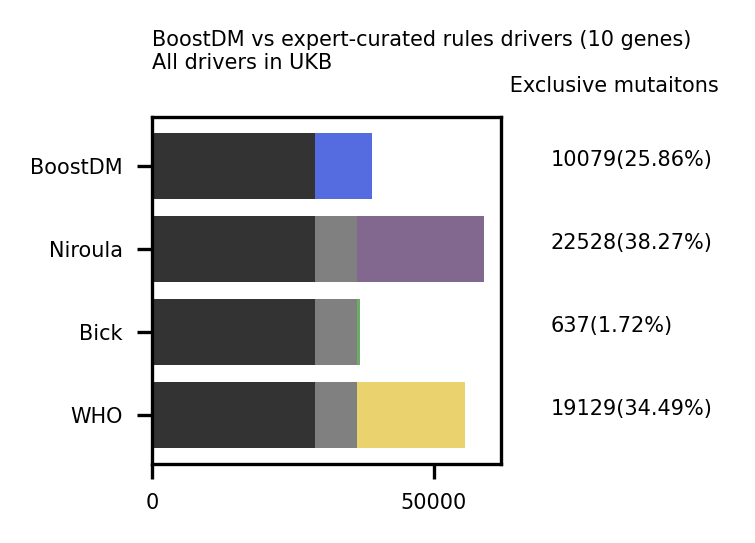

In [16]:
######
#BARPLOT
######
plt.figure(figsize=(1.5, 1.5))

Rules_matrix_comp = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['SYMBOL'].isin(['CHEK2', 'MDM4'])]

Overlapping_all = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&\
                                    (Rules_matrix_comp['Niroula']==1)&\
                                    (Rules_matrix_comp['Bick']==1)&\
                                    (Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

Overlapping_3R = len(Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)&\
                                          (Rules_matrix_comp['Bick']==1)&\
                                          (Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

BoostDM = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)]['ID2'].to_list())


Niroula = len(Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)]['ID2'].to_list())

Bick = len(Rules_matrix_comp[(Rules_matrix_comp['Bick']==1)]['ID2'].to_list())

WHO = len(Rules_matrix_comp[(Rules_matrix_comp['WHO']==1)]['ID2'].to_list())


# # create data
x = ['WHO', 'Bick', 'Niroula', 'BoostDM']
y1 = [Overlapping_all, Overlapping_all, Overlapping_all, Overlapping_all]
y2 = [Overlapping_3R-Overlapping_all, Overlapping_3R-Overlapping_all, Overlapping_3R-Overlapping_all, 0]
y3 = [0, 0, 0, BoostDM-Overlapping_all]
y4 = [0, 0, Niroula-Overlapping_3R, 0]
y5 = [0, Bick-Overlapping_3R, 0, 0]
y6 = [WHO-Overlapping_3R, 0, 0, 0]
h = 0.6
size_param = 5

# plot bars in stack manner
#     plt.figure(figsize=(4, 2))
max_len = max([BoostDM,Niroula,Bick,WHO])
plt.barh(x, y1, color='#333333')
plt.barh(x, y2, left=y1, color='grey')
plt.barh(x, y3, left=[sum(triplet) for triplet in zip(y1, y2)], color='#556CE0')
plt.barh(x, y4, left=[sum(triplet) for triplet in zip(y1, y2)], color='#82678E')
plt.barh(x, y5, left=[sum(triplet) for triplet in zip(y1, y2)], color='#6DAC67')
plt.barh(x, y6, left=[sum(triplet) for triplet in zip(y1, y2)], color='#EAD36E')
plt.text(max_len+(max_len/5), 0, str(round(WHO-(Overlapping_3R-Overlapping_all)-Overlapping_all))+'('+str(round((WHO-(Overlapping_3R-Overlapping_all)-Overlapping_all)/WHO*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 1, str(round(Bick-(Overlapping_3R-Overlapping_all)-Overlapping_all))+'('+str(round((Bick-(Overlapping_3R-Overlapping_all)-Overlapping_all)/Bick*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 2, str(round(Niroula-(Overlapping_3R-Overlapping_all)-Overlapping_all))+'('+str(round((Niroula-(Overlapping_3R-Overlapping_all)-Overlapping_all)/Niroula*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 3, str(round(BoostDM-Overlapping_all))+'('+str(round((BoostDM-Overlapping_all)/BoostDM*100, 2))+'%)', size=size_param)
# plt.text(20, 0, str(round(Inter/Boost*100, 2))+'%')
plt.yticks(fontsize=size_param)
plt.xticks(fontsize=size_param)
plt.title("BoostDM vs expert-curated rules drivers (10 genes)\nAll drivers in UKB\n                                                      Exclusive mutaitons ", fontsize=size_param, loc="left") 

# 5. Comparison of expert curated rules (intersection) with boostDM-CH. Total ASXL1 drivers in UKB

Text(0.0, 1.0, 'BoostDM vs expert-curated rules drivers (10 genes)\nAll drivers in UKB\n                                                      Exclusive mutaitons ')

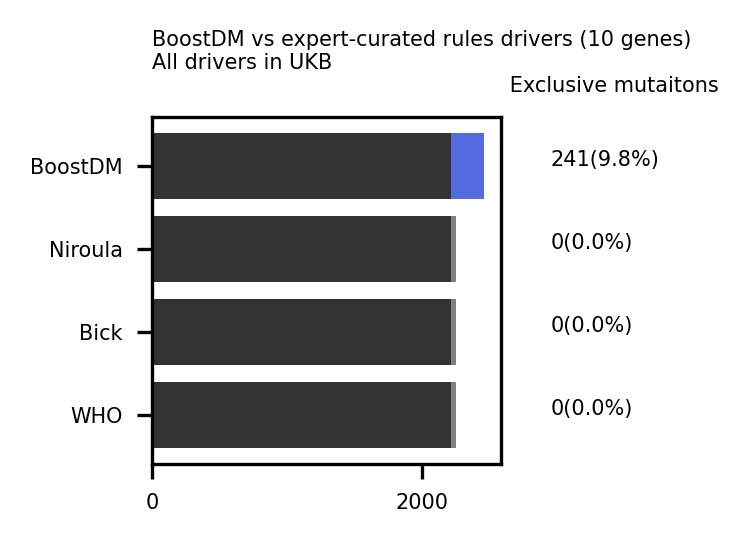

In [17]:
######
#BARPLOT ASXL1
######
plt.figure(figsize=(1.5, 1.5))

Rules_matrix_comp = boostDM_predictions_nonHN[boostDM_predictions_nonHN['SYMBOL']=='ASXL1']

Overlapping_all = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&\
                                    (Rules_matrix_comp['Niroula']==1)&\
                                    (Rules_matrix_comp['Bick']==1)&\
                                    (Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

Overlapping_3R = len(Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)&\
                                          (Rules_matrix_comp['Bick']==1)&\
                                          (Rules_matrix_comp['WHO']==1)]['ID2'].to_list())

BoostDM = len(Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)]['ID2'].to_list())


Niroula = len(Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)]['ID2'].to_list())

Bick = len(Rules_matrix_comp[(Rules_matrix_comp['Bick']==1)]['ID2'].to_list())

WHO = len(Rules_matrix_comp[(Rules_matrix_comp['WHO']==1)]['ID2'].to_list())


# # create data
x = ['WHO', 'Bick', 'Niroula', 'BoostDM']
y1 = [Overlapping_all, Overlapping_all, Overlapping_all, Overlapping_all]
y2 = [Overlapping_3R-Overlapping_all, Overlapping_3R-Overlapping_all, Overlapping_3R-Overlapping_all, 0]
y3 = [0, 0, 0, BoostDM-Overlapping_all]
y4 = [0, 0, Niroula-Overlapping_3R, 0]
y5 = [0, Bick-Overlapping_3R, 0, 0]
y6 = [WHO-Overlapping_3R, 0, 0, 0]
h = 0.6
size_param = 5

# plot bars in stack manner
#     plt.figure(figsize=(4, 2))
max_len = max([BoostDM,Niroula,Bick,WHO])
plt.barh(x, y1, color='#333333')
plt.barh(x, y2, left=y1, color='grey')
plt.barh(x, y3, left=[sum(triplet) for triplet in zip(y1, y2)], color='#556CE0')
plt.barh(x, y4, left=[sum(triplet) for triplet in zip(y1, y2)], color='#82678E')
plt.barh(x, y5, left=[sum(triplet) for triplet in zip(y1, y2)], color='#6DAC67')
plt.barh(x, y6, left=[sum(triplet) for triplet in zip(y1, y2)], color='#EAD36E')
plt.text(max_len+(max_len/5), 0, str(round(WHO-(Overlapping_3R-Overlapping_all)-Overlapping_all))+'('+str(round((WHO-(Overlapping_3R-Overlapping_all)-Overlapping_all)/WHO*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 1, str(round(Bick-(Overlapping_3R-Overlapping_all)-Overlapping_all))+'('+str(round((Bick-(Overlapping_3R-Overlapping_all)-Overlapping_all)/Bick*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 2, str(round(Niroula-(Overlapping_3R-Overlapping_all)-Overlapping_all))+'('+str(round((Niroula-(Overlapping_3R-Overlapping_all)-Overlapping_all)/Niroula*100, 2))+'%)', size=size_param)
plt.text(max_len+(max_len/5), 3, str(round(BoostDM-Overlapping_all))+'('+str(round((BoostDM-Overlapping_all)/BoostDM*100, 2))+'%)', size=size_param)
# plt.text(20, 0, str(round(Inter/Boost*100, 2))+'%')
plt.yticks(fontsize=size_param)
plt.xticks(fontsize=size_param)
plt.title("BoostDM vs expert-curated rules drivers (10 genes)\nAll drivers in UKB\n                                                      Exclusive mutaitons ", fontsize=size_param, loc="left") 

# 6. Comparison of expert curated rules (intersection) with boostDM-CH.
## Gene proportions

In [18]:
### Mutational landscape by gender
Rules_matrix_comp = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['SYMBOL'].isin(['CHEK2', 'MDM4'])]

Mut_case = []
for gene in Rules_matrix_comp['SYMBOL'].unique():
    
    GENE = Rules_matrix_comp[Rules_matrix_comp['SYMBOL']==gene]
    
    Overlapping_all = len(GENE[(GENE['BoostDM']==1)&\
                                    (GENE['Niroula']==1)&\
                                    (GENE['Bick']==1)&\
                                    (GENE['WHO']==1)]['ID2'].to_list())
    Overlapping_3R = len(GENE[(GENE['BoostDM']==0)&\
                                    (GENE['Niroula']==1)&\
                                    (GENE['Bick']==1)&\
                                    (GENE['WHO']==1)]['ID2'].to_list())
    BoostDM = len(GENE[(GENE['BoostDM']==1)]['ID2'].to_list())
   
    #     freq = len(maf_can_PASS_VAF_nonrep.groupby(['SYMBOL'])['case'].unique()[gene])
    Mut_case.append([gene, Overlapping_all, Overlapping_3R, BoostDM-Overlapping_all])
Mut_case

[['SRSF2', 417, 0, 154],
 ['TET2', 9398, 5849, 426],
 ['DNMT3A', 13894, 1168, 7653],
 ['ASXL1', 2218, 32, 241],
 ['SF3B1', 298, 19, 409],
 ['TP53', 1341, 353, 812],
 ['PPM1D', 811, 0, 66],
 ['IDH2', 130, 15, 0],
 ['GNAS', 222, 0, 29],
 ['U2AF1', 172, 0, 289]]

In [19]:
Mut_case = pd.DataFrame(Mut_case, columns = ['Gene', 'Intercect', 'Intercect_exc', 'BoostDM_exc']).sort_values('Intercect', ascending=False)
Mut_case.reset_index()

,index,Gene,Intercect,Intercect_exc,BoostDM_exc
0,2,DNMT3A,13894,1168,7653
1,1,TET2,9398,5849,426
2,3,ASXL1,2218,32,241
3,5,TP53,1341,353,812
4,6,PPM1D,811,0,66
5,0,SRSF2,417,0,154
6,4,SF3B1,298,19,409
7,8,GNAS,222,0,29
8,9,U2AF1,172,0,289
9,7,IDH2,130,15,0


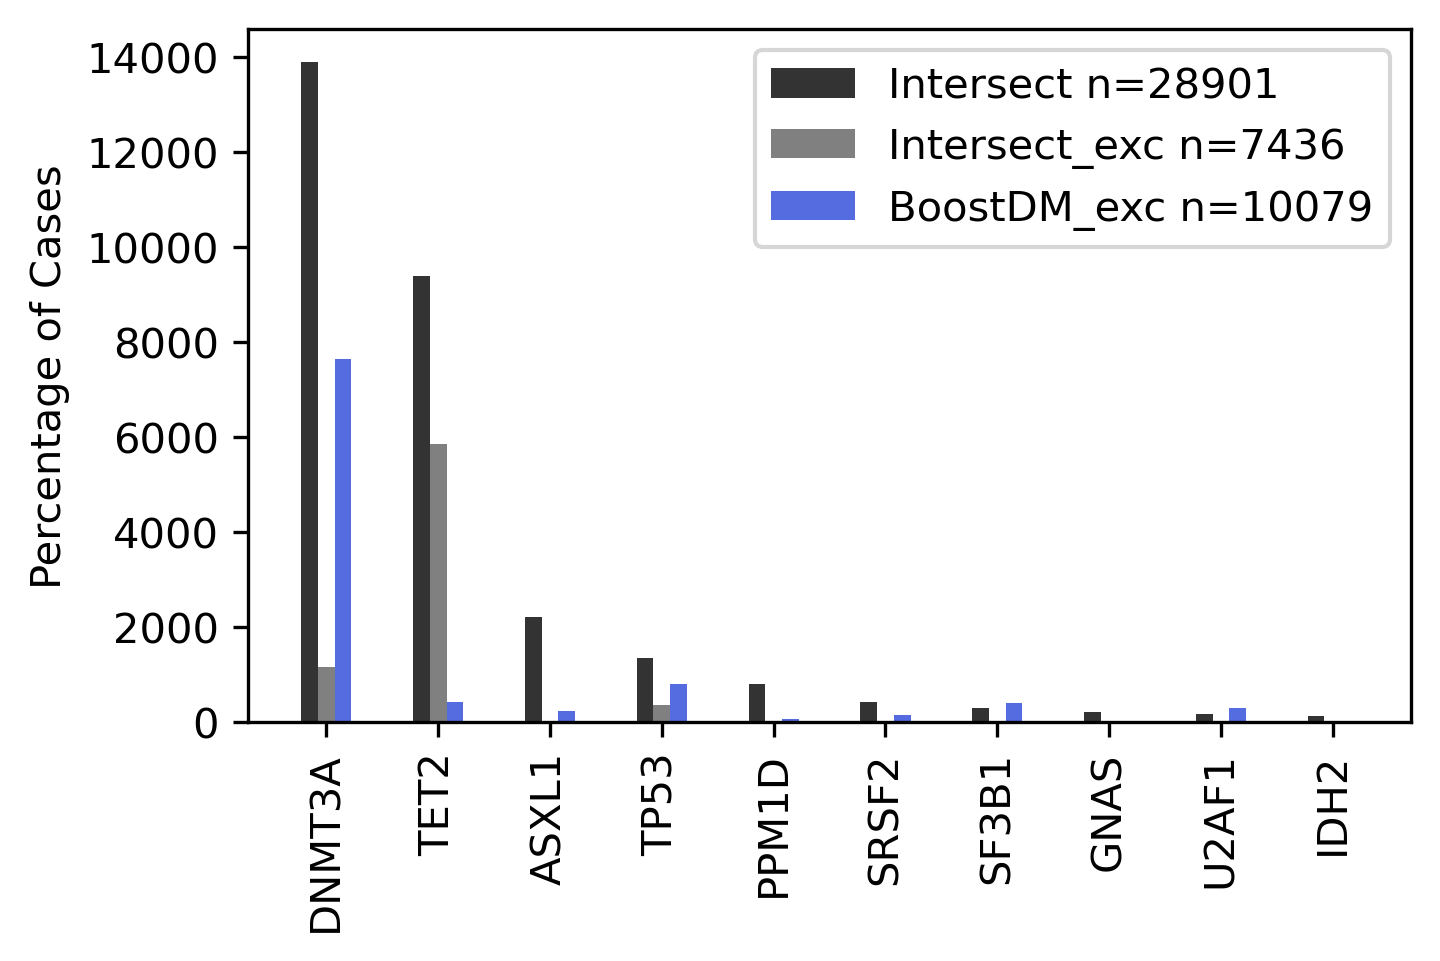

In [20]:
import numpy as np  
import matplotlib.pyplot as plt  

X = Mut_case.Gene
White = Mut_case.Intercect
Mixed = Mut_case.Intercect_exc
Asian = Mut_case.BoostDM_exc

X_axis = np.arange(len(X)) 

plt.figure(figsize=(5, 3))
plt.bar(X_axis - 0.15, White, 0.15, label = f'Intersect n={Mut_case.Intercect.sum()}', color ='#333333') 
plt.bar(X_axis, Mixed, 0.15, label = f'Intersect_exc n={Mut_case.Intercect_exc.sum()}', color ='grey') 
plt.bar(X_axis + 0.15, Asian, 0.15, label = f'BoostDM_exc n={Mut_case.BoostDM_exc.sum()}', color ='#556CE0') 

plt.xticks(X_axis, X, rotation=90) 
plt.ylabel("Percentage of Cases")  
plt.legend() 
plt.show() 

In [21]:
# Mutational landscape by gender
Rules_matrix_comp = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['SYMBOL'].isin(['CHEK2', 'MDM4'])]

Mut_case = []
for gene in Rules_matrix_comp['SYMBOL'].unique():
    GENE = Rules_matrix_comp[Rules_matrix_comp['SYMBOL']==gene]
    Overlapping_all = len(set(GENE[(GENE['BoostDM']==1)&\
                                    (GENE['Niroula']==1)&\
                                    (GENE['Bick']==1)&\
                                    (GENE['WHO']==1)]['patient'].to_list()))
    Overlapping_3R = len(set(GENE[(GENE['BoostDM']==0)&\
                                    (GENE['Niroula']==1)&\
                                    (GENE['Bick']==1)&\
                                    (GENE['WHO']==1)]['patient'].to_list()))
    BoostDM = len(set(GENE[(GENE['BoostDM']==1)]['patient'].to_list()))
    Total= Overlapping_all+Overlapping_3R+(BoostDM-Overlapping_all)

   
    #     freq = len(maf_can_PASS_VAF_nonrep.groupby(['SYMBOL'])['case'].unique()[gene])
    Mut_case.append([gene, Total, Overlapping_all/Total, Overlapping_3R/Total, (BoostDM-Overlapping_all)/Total])
Mut_case

[['SRSF2', 566, 0.73, 0.00, 0.27],
 ['TET2', 15272, 0.60, 0.38, 0.03],
 ['DNMT3A', 21923, 0.62, 0.05, 0.33],
 ['ASXL1', 2473, 0.89, 0.01, 0.10],
 ['SF3B1', 717, 0.42, 0.03, 0.56],
 ['TP53', 2496, 0.54, 0.14, 0.32],
 ['PPM1D', 870, 0.92, 0.00, 0.08],
 ['IDH2', 145, 0.90, 0.10, 0.00],
 ['GNAS', 251, 0.88, 0.00, 0.12],
 ['U2AF1', 458, 0.37, 0.00, 0.63]]

In [22]:
Mut_case = pd.DataFrame(Mut_case, columns = ['Gene', 'Num_mut', 'Intersect', 'Intersect_exc', 'BoostDM_exc']).sort_values('Num_mut', ascending=False)
Mut_case = Mut_case.reset_index(drop=True)
Mut_case

,Gene,Num_mut,Intersect,Intersect_exc,BoostDM_exc
0,DNMT3A,21923,0.619669,0.053186,0.327145
1,TET2,15272,0.595141,0.377750,0.027108
2,TP53,2496,0.535657,0.141026,0.323317
3,ASXL1,2473,0.890821,0.012940,0.096239
4,PPM1D,870,0.924138,0.000000,0.075862
5,SF3B1,717,0.415621,0.026499,0.557880
6,SRSF2,566,0.727915,0.000000,0.272085
7,U2AF1,458,0.371179,0.000000,0.628821
8,GNAS,251,0.884462,0.000000,0.115538
9,IDH2,145,0.896552,0.103448,0.000000


In [23]:
# Mutational landscape by gender
Rules_matrix_comp = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['SYMBOL'].isin(['CHEK2', 'MDM4'])]

Mut_case_num = []
for gene in Rules_matrix_comp['SYMBOL'].unique():
    GENE = Rules_matrix_comp[Rules_matrix_comp['SYMBOL']==gene]
    Overlapping_all = len(set(GENE[(GENE['BoostDM']==1)&\
                                    (GENE['Niroula']==1)&\
                                    (GENE['Bick']==1)&\
                                    (GENE['WHO']==1)]['patient'].to_list()))
    Overlapping_3R = len(set(GENE[(GENE['BoostDM']==0)&\
                                    (GENE['Niroula']==1)&\
                                    (GENE['Bick']==1)&\
                                    (GENE['WHO']==1)]['patient'].to_list()))
    BoostDM = len(set(GENE[(GENE['BoostDM']==1)]['patient'].to_list()))
    Total= Overlapping_all+Overlapping_3R+(BoostDM-Overlapping_all)

   
    #     freq = len(maf_can_PASS_VAF_nonrep.groupby(['SYMBOL'])['case'].unique()[gene])
    Mut_case_num.append([gene, Total, Overlapping_all, Overlapping_3R, (BoostDM-Overlapping_all)])
Mut_case_num = pd.DataFrame(Mut_case_num, columns = ['Gene', 'Num_mut', 'Intersect', 'Intersect_exc', 'BoostDM_exc']).sort_values('Num_mut', ascending=False)
Mut_case_num = Mut_case_num.reset_index(drop=True)
Mut_case_num

,Gene,Num_mut,Intersect,Intersect_exc,BoostDM_exc
0,DNMT3A,21923,13585,1166,7172
1,TET2,15272,9089,5769,414
2,TP53,2496,1337,352,807
3,ASXL1,2473,2203,32,238
4,PPM1D,870,804,0,66
5,SF3B1,717,298,19,400
6,SRSF2,566,412,0,154
7,U2AF1,458,170,0,288
8,GNAS,251,222,0,29
9,IDH2,145,130,15,0


In [24]:
Mut_case_num = list(Mut_case_num['BoostDM_exc'])+\
                list(Mut_case_num['Intersect'])+\
                list(Mut_case_num['Intersect_exc'])

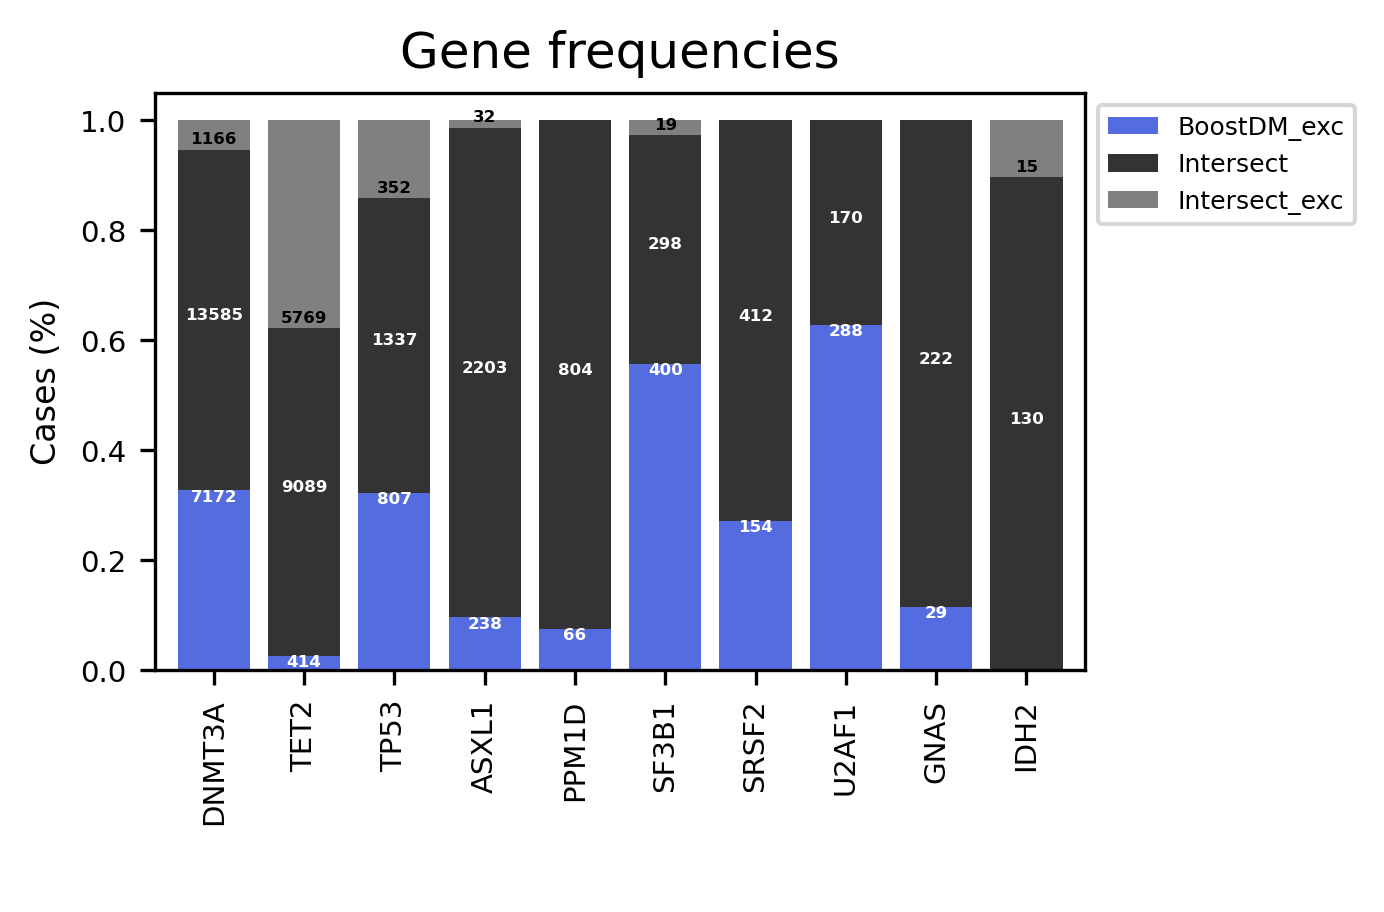

In [25]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

genes15_col = {
            'BoostDM_exc':'#556CE0',
            'Intersect_exc':'grey',
            'Intersect':'#333333'
           }

fig, ax = plt.subplots(figsize=(3, 2.5))

# plot data in stack manner of bar type
bars = Mut_case[['Gene', 'BoostDM_exc', 'Intersect', 'Intersect_exc']].plot(x='Gene', kind='bar', stacked=True,
        title='Gene frequencies', figsize=(4, 2.5),\
        color=[genes15_col[gene] for gene in ['BoostDM_exc', 'Intersect', 'Intersect_exc']], ax=ax, width=0.8)

y_offset = -0.04
# For each patch (basically each rectangle within the bar), add a label.
for i, bar in enumerate(bars.patches):   
    if i <10:
        position = bar.get_height()-0.02
        color='w'
    elif (i >= 10) and (i < 20):
        position = bar.get_height()/2 + bar.get_y()
        color='w'
    else:
        position = bar.get_y()+0.01
        color='k'
        
    if Mut_case_num[i] == 0:
        text_todd = ' '
    else:
        text_todd = Mut_case_num[i]
        
    ax.text(
        # Put the text in the middle of each bar. get_x returns the start
        # so we add half the width to get to the middle.
        bar.get_x() + bar.get_width() / 2,
        # Vertically, add the height of the bar to the start of the bar,
        # along with the offset.
        position,
        # This is actual value we'll show.
        text_todd,
        # Center the labels and style them a bit.
        ha='center',
        color=color,
        weight='bold',
        size=4)
    
plt.legend(loc="upper left", fontsize=6, bbox_to_anchor=(1, 1))
plt.xlabel(' ')
plt.ylabel('Cases (%)', fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.show()

In [26]:
ukb_Overlap_all = Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)&\
                                    (Rules_matrix_comp['Bick']==1)&\
                                    (Rules_matrix_comp['WHO']==1)]['ID2'].to_list()
Rules_matrix_comp['Intersect_rules'] = np.where(Rules_matrix_comp['ID2'].isin(ukb_Overlap_all), 1, 0)

ukb_boostDM_exc = Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Intersect_rules']==0)]['ID2'].to_list()
Rules_matrix_comp['BoostDM_exc'] = np.where(Rules_matrix_comp['ID2'].isin(ukb_boostDM_exc), 1, 0)

ukb_Niroula_exc = Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==0)&(Rules_matrix_comp['Intersect_rules']==1)]['ID2'].to_list()
Rules_matrix_comp['Intersect_exc'] = np.where(Rules_matrix_comp['ID2'].isin(ukb_Niroula_exc), 1, 0)

ukb_Niroula_exc = Rules_matrix_comp[(Rules_matrix_comp['BoostDM']==1)&(Rules_matrix_comp['Intersect_rules']==1)]['ID2'].to_list()
Rules_matrix_comp['Intersect_boostDM'] = np.where(Rules_matrix_comp['ID2'].isin(ukb_Niroula_exc), 1, 0)

ukb_boostDM_exc = Rules_matrix_comp[(Rules_matrix_comp['Niroula']==1)&(Rules_matrix_comp['Intersect_rules']==0)]['ID2'].to_list()
Rules_matrix_comp['Niroula_exc'] = np.where(Rules_matrix_comp['ID2'].isin(ukb_boostDM_exc), 1, 0)

ukb_boostDM_exc = Rules_matrix_comp[(Rules_matrix_comp['Bick']==1)&(Rules_matrix_comp['Intersect_rules']==0)]['ID2'].to_list()
Rules_matrix_comp['Bick_exc'] = np.where(Rules_matrix_comp['ID2'].isin(ukb_boostDM_exc), 1, 0)

ukb_boostDM_exc = Rules_matrix_comp[(Rules_matrix_comp['WHO']==1)&(Rules_matrix_comp['Intersect_rules']==0)]['ID2'].to_list()
Rules_matrix_comp['WHO_exc'] = np.where(Rules_matrix_comp['ID2'].isin(ukb_boostDM_exc), 1, 0)

In [27]:
boostDM_class = Rules_matrix_comp[(Rules_matrix_comp['Intersect_exc']==1)|(Rules_matrix_comp['BoostDM_exc']==1)|(Rules_matrix_comp['Intersect_boostDM']==1)]

In [28]:
Classifier = []

for i in range(len(boostDM_class)):
    row = boostDM_class.iloc[i,:]
    if row.Intersect_exc ==1:
        Classifier.append('Intersect_exc')
    elif row.BoostDM_exc ==1:
        Classifier.append('BoostDM_exc')
    elif row.Intersect_boostDM ==1:
        Classifier.append('Intersect_boostDM')
    else:
        print('ERROR')

boostDM_class['Classifier']=Classifier

/tmp/jobs/jramis/9874679/ipykernel_11255/4226851310.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boostDM_class['Classifier']=Classifier


In [29]:
# Mutational landscape by gender
gene10 = ['DNMT3A', 'TET2', 'ASXL1', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2', 'U2AF1', 'GNAS', 'IDH2']
Mut_case = []
for cohort in ['BoostDM_exc', 'Intersect_boostDM', 'Intersect_exc']:
    Mut_gene= []
    cohort_mut = boostDM_class[boostDM_class['Classifier']==cohort]
    Total = len(cohort_mut)
    for gene in gene10:
        GENE = cohort_mut[cohort_mut['SYMBOL']==gene]
        Mut_gene.append(len(GENE)/Total)
    Mut_case.append([cohort, Total]+Mut_gene)
Mut_case_num = pd.DataFrame(Mut_case, columns = ['Cohort', 'Num_mut']+gene10).sort_values('Num_mut', ascending=False)
Mut_case_num = Mut_case_num.reset_index(drop=True)
Mut_case_num

,Cohort,Num_mut,DNMT3A,TET2,ASXL1,TP53,PPM1D,SF3B1,SRSF2,U2AF1,GNAS,IDH2
0,Intersect_boostDM,28901,0.480745,0.325179,0.076745,0.046400,0.028061,0.010311,0.014429,0.005951,0.007681,0.004498
1,BoostDM_exc,10079,0.759302,0.042266,0.023911,0.080564,0.006548,0.040579,0.015279,0.028673,0.002877,0.000000
2,Intersect_exc,7436,0.157074,0.786579,0.004303,0.047472,0.000000,0.002555,0.000000,0.000000,0.000000,0.002017


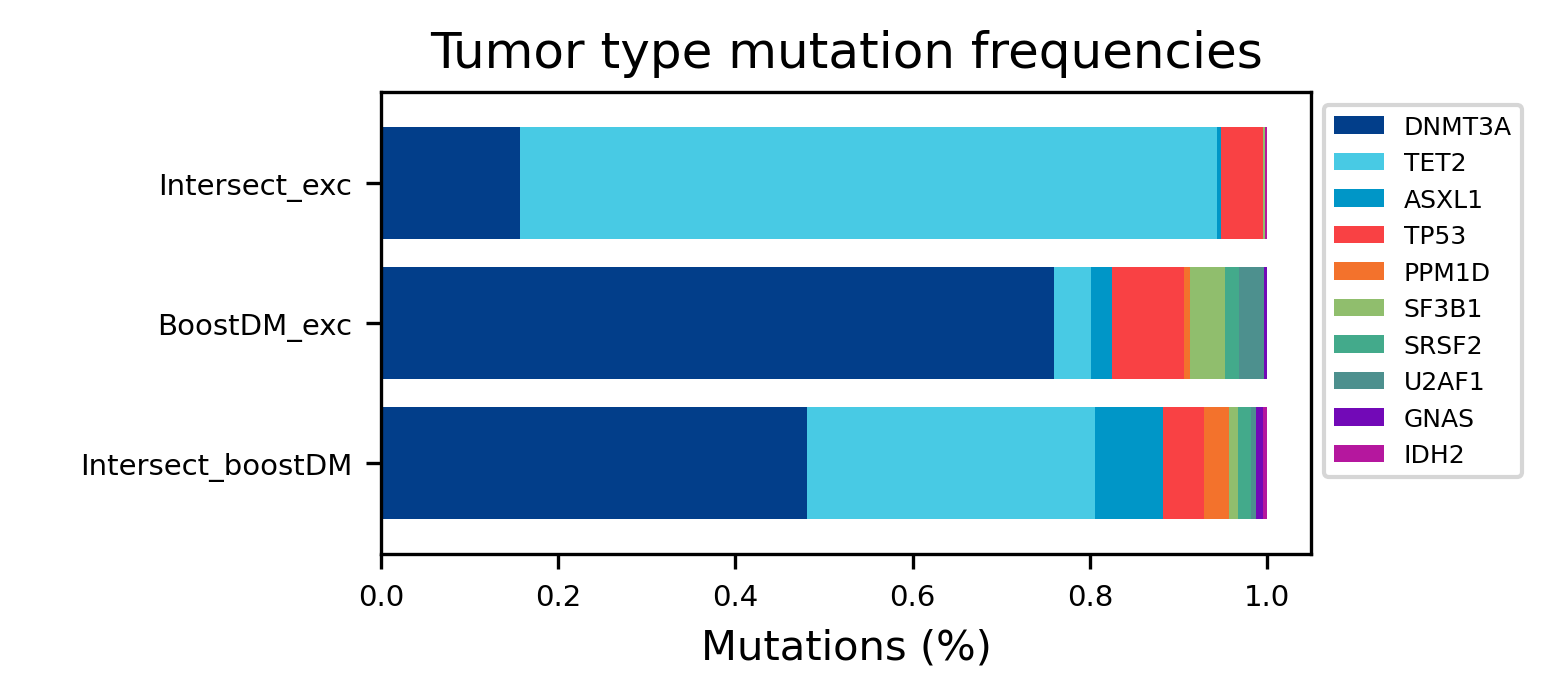

In [30]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

genes15_col = {
           'DNMT3A':'#023E8A',
           'TET2':'#48CAE4',
           'ASXL1':'#0096C7',
           'CHEK2':'#F8961E',
           'TP53':'#F94144',
           'PPM1D':'#F3722C',
           'MDM4':'#F9C74F',
           'SF3B1':'#90BE6D',
           'SRSF2':'#43AA8B',
           'U2AF1':'#4D908E',   
           'GNAS':'#7209B7',
           'IDH2':'#B5179E'      
           }

fig, ax = plt.subplots(figsize=(4, 2))

# plot data in stack manner of bar type
bars = Mut_case_num[['Cohort']+gene10].plot(x='Cohort', kind='barh', stacked=True,
        title='Tumor type mutation frequencies',\
        color=[genes15_col[gene] for gene in gene10], ax=ax, width=0.8)
    
plt.legend(loc="upper left", fontsize=6, bbox_to_anchor=(1, 1))
plt.xlabel('Mutations (%)')
plt.ylabel(' ', fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(fontsize=7)
plt.show()